<a href="https://colab.research.google.com/github/a-donat/Data-Science-Portfolio/blob/master/Customer_Propensity_to_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Set-Up

## I.A. Download Dataset from Kaggle

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d jssunmathi/churn-modelling


Dataset URL: https://www.kaggle.com/datasets/jssunmathi/churn-modelling
License(s): unknown
100% 262k/262k [00:00<00:00, 810kB/s]
100% 262k/262k [00:00<00:00, 809kB/s]


In [4]:
!unzip '/content/churn-modelling.zip' -d '/content/churn-modelling'


Archive:  /content/churn-modelling.zip
  inflating: /content/churn-modelling/Churn_Modelling.csv  


## I.B. Import Libraries

In [ ]:
!pip install pycaret

In [51]:
import pandas as pd

In [52]:
import numpy as np

In [53]:
from pycaret.classification import *
from sklearn.model_selection import train_test_split

In [54]:
import matplotlib.pyplot as plt

# II. Load and Validate Dataset

In [55]:
churn_df = pd.read_csv('/content/churn-modelling/Churn_Modelling.csv')

In [56]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [57]:
churn_df.nunique()

,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


In [58]:
pd.crosstab(churn_df['IsActiveMember'], churn_df['Exited'])

Exited,0,1
IsActiveMember,,
0,3547,1302
1,4416,735


In [59]:
churn_df = churn_df.drop(columns=['CustomerId', 'Surname']).copy()

In [60]:
churn_train, churn_test = train_test_split(
    churn_df, test_size=0.20, stratify=churn_df["Exited"], random_state=1)

# III. PyCaret Classification

In [81]:
exp_clf101 = setup(
    data=churn_train, target='Exited',
    categorical_features=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'],
    ignore_features=['RowNumber'], session_id=123, fold=5)

,Description,Value
0,Session id,123
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(8000, 14)"
4,Transformed data shape,"(8000, 15)"
5,Transformed train set shape,"(5600, 15)"
6,Transformed test set shape,"(2400, 15)"
7,Ignore features,1
8,Numeric features,8
9,Categorical features,4


In [82]:
best_model = compare_models(sort='Recall')


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7927,0.6911,0.5197,0.4924,0.5055,0.3745,0.3748,0.1560
xgboost,Extreme Gradient Boosting,0.8538,0.8402,0.5154,0.6895,0.5894,0.5028,0.5109,0.2660
lightgbm,Light Gradient Boosting Machine,0.8586,0.8532,0.5057,0.7193,0.5931,0.5107,0.5228,1.7020
gbc,Gradient Boosting Classifier,0.8654,0.8671,0.4847,0.7712,0.5943,0.5187,0.5393,1.1360
ada,Ada Boost Classifier,0.8518,0.8499,0.4716,0.7076,0.5642,0.4794,0.4946,0.5740
rf,Random Forest Classifier,0.8612,0.8496,0.4663,0.7611,0.5777,0.5004,0.5223,0.7400
et,Extra Trees Classifier,0.8548,0.8406,0.4610,0.7283,0.5642,0.4823,0.5007,0.5980
qda,Quadratic Discriminant Analysis,0.6277,0.5483,0.3637,0.2360,0.2277,0.0480,0.0527,0.1400
lda,Linear Discriminant Analysis,0.8209,0.7713,0.3444,0.6099,0.4391,0.3423,0.3627,0.1400
lr,Logistic Regression,0.8248,0.7688,0.2971,0.6606,0.4085,0.3225,0.3589,0.8020


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [83]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8464,0.8344,0.4716,0.6792,0.5567,0.4675,0.4788
1,0.8527,0.8549,0.5044,0.6886,0.5823,0.4954,0.5043
2,0.8688,0.8566,0.5482,0.7396,0.6297,0.5521,0.5612
3,0.8589,0.8397,0.5307,0.7035,0.6050,0.5212,0.5288
4,0.8420,0.8155,0.5219,0.6364,0.5735,0.4777,0.4812
Mean,0.8538,0.8402,0.5154,0.6895,0.5894,0.5028,0.5109
Std,0.0094,0.0150,0.0261,0.0336,0.0255,0.0307,0.0310


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [84]:
xgb_tuned_recall = tune_model(xgb, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.2045,0.7820,1.0000,0.2045,0.3395,0.0000,0.0000
1,0.2036,0.8152,1.0000,0.2036,0.3383,0.0000,0.0000
2,0.2036,0.8089,1.0000,0.2036,0.3383,0.0000,0.0000
3,0.2036,0.7669,1.0000,0.2036,0.3383,0.0000,0.0000
4,0.2036,0.7869,1.0000,0.2036,0.3383,0.0000,0.0000
Mean,0.2037,0.7920,1.0000,0.2037,0.3385,0.0000,0.0000
Std,0.0004,0.0178,0.0000,0.0004,0.0005,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [85]:
xgb_tuned_accuracy = tune_model(xgb, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8188,0.8364,0.6681,0.5464,0.6012,0.4854,0.4895
1,0.8116,0.8575,0.7018,0.5281,0.6026,0.4824,0.4908
2,0.8205,0.8514,0.6930,0.5467,0.6112,0.4967,0.5026
3,0.7964,0.8278,0.6491,0.5000,0.5649,0.4349,0.4412
4,0.7875,0.8102,0.6535,0.4838,0.5560,0.4204,0.4286
Mean,0.8070,0.8366,0.6731,0.5210,0.5872,0.4640,0.4705
Std,0.0129,0.0169,0.0210,0.0252,0.0223,0.0304,0.0297


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [21]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8732,0.8651,0.4783,0.8333,0.6077,0.5386,0.5682
1,0.8464,0.8132,0.4211,0.7059,0.5275,0.4427,0.4638
2,0.8661,0.8590,0.4912,0.7671,0.5989,0.5231,0.5419
3,0.8625,0.8622,0.4649,0.7681,0.5792,0.5029,0.5256
4,0.8571,0.8605,0.4737,0.7297,0.5745,0.4933,0.5099
5,0.8696,0.8732,0.5000,0.7808,0.6096,0.5359,0.5550
6,0.8714,0.8554,0.5000,0.7917,0.6129,0.5405,0.5610
7,0.8607,0.8505,0.4649,0.7571,0.5761,0.4984,0.5196
8,0.8750,0.8821,0.5263,0.7895,0.6316,0.5599,0.5766


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

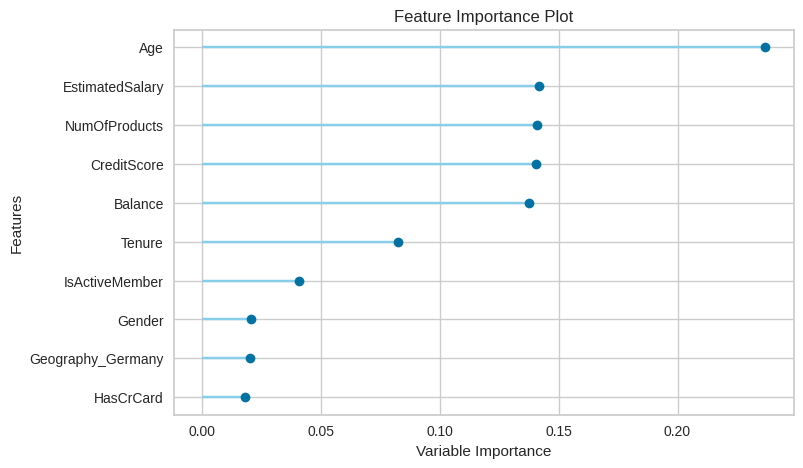

In [22]:
plot_model(rf, plot='feature')

In [87]:
xgb_tuned_accuracy = finalize_model(xgb_tuned_accuracy)

In [86]:
# note: overfitting!
xgb_preds = predict_model(xgb_tuned_accuracy, data=churn_train)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9411,0.9555,0.7877,0.9113,0.8450,0.8089,0.8122


# IV. Exploratory Analysis

In [27]:
np.random.rand(5)

array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897])

In [65]:
churn_train["noise"] = (np.random.rand(churn_train.shape[0]) - .5) * .8

In [66]:
churn_train["age_noisy"] = churn_train["Age"] + churn_train["noise"]

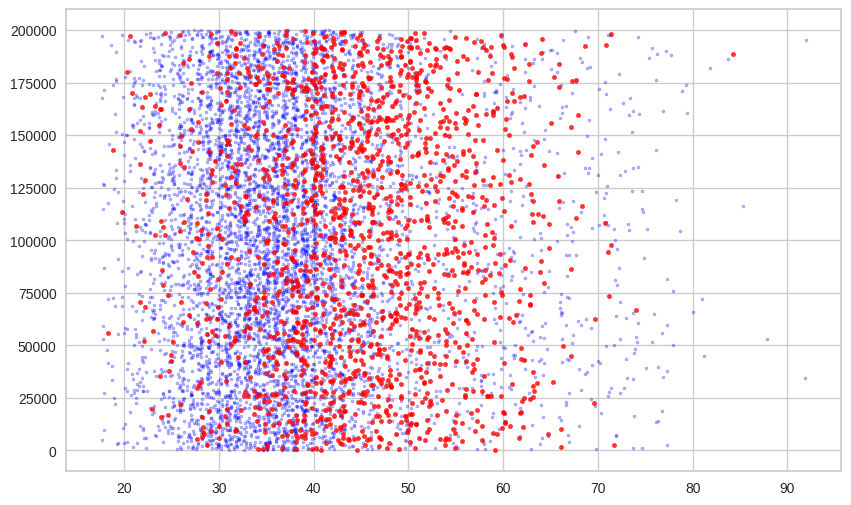

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    data=churn_train[churn_train["Exited"]==0],
    x="age_noisy", y="EstimatedSalary", color="blue", s=5, alpha=.3)
ax.scatter(
    data=churn_train[churn_train["Exited"]==1],
    x="age_noisy", y="EstimatedSalary", color="red", s=10, alpha=.8)


In [44]:
churn_train[churn_train["Age"] < 43]["Exited"].mean()

0.11836088638761871

In [43]:
churn_train[churn_train["Age"] >= 43]["Exited"].mean()

0.4135695764909248

In [45]:
churn_train[churn_train["Age"] >= 43].groupby("Exited")["EstimatedSalary"].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,1357.0,98334.0,56298.0,487.0,51587.0,95463.0,144584.0,199662.0
1,957.0,102146.0,58109.0,12.0,51566.0,103714.0,153357.0,199379.0


In [46]:
churn_train[["Age", "EstimatedSalary"]].corr()

,Age,EstimatedSalary
Age,1.000000,-0.004948
EstimatedSalary,-0.004948,1.000000


In [48]:
pd.crosstab(churn_train[churn_train["Age"] >= 43]["Exited"], churn_train[churn_train["Age"] >= 43]["NumOfProducts"])

NumOfProducts,1,2,3,4
Exited,,,,
0,641,711,5,0
1,674,155,95,33


In [50]:
pd.crosstab(churn_train[churn_train["Age"] < 43]["Exited"], churn_train[churn_train["Age"] < 43]["NumOfProducts"])

NumOfProducts,1,2,3,4
Exited,,,,
0,2276,2705,32,0
1,454,119,81,19


In [68]:
over_43 = churn_train[churn_train["Age"] >= 43].copy()
under_43 = churn_train[churn_train["Age"] < 43].copy()

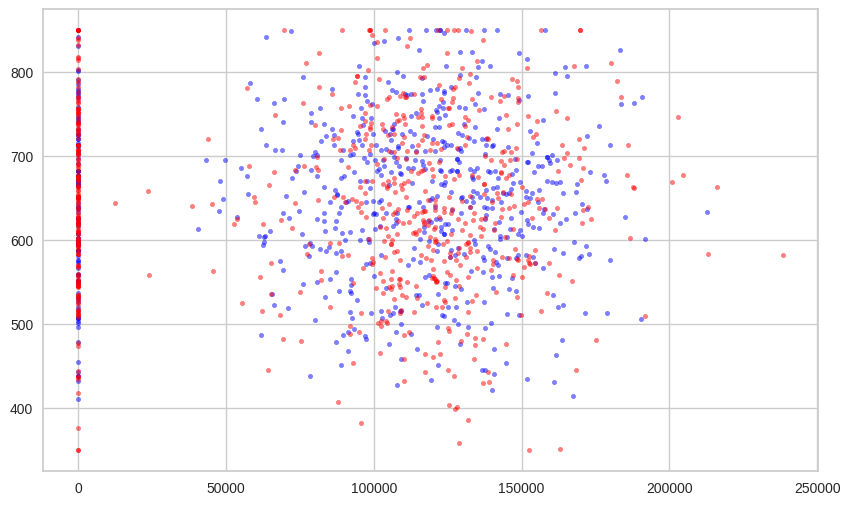

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    data=over_43[(over_43["NumOfProducts"]==1) & (over_43["Exited"]==0)],
    x="Balance", y="CreditScore", color="blue", s=10, alpha=.5)
ax.scatter(
    data=over_43[(over_43["NumOfProducts"]==1) & (over_43["Exited"]==1)],
    x="Balance", y="CreditScore", color="red", s=10, alpha=.5)


In [72]:
pd.crosstab(over_43["Balance"]==0, over_43["Exited"])

Exited,0,1
Balance,,
False,828,714
True,529,243


In [73]:
pd.crosstab(over_43[over_43["NumOfProducts"]==1]["Balance"]==0,
            over_43[over_43["NumOfProducts"]==1]["Exited"])

Exited,0,1
Balance,,
False,537,509
True,104,165


In [74]:
pd.crosstab(over_43[over_43["NumOfProducts"]==2]["Balance"]==0,
            over_43[over_43["NumOfProducts"]==2]["Exited"])

Exited,0,1
Balance,,
False,291,118
True,420,37


In [75]:
pd.crosstab(over_43[over_43["NumOfProducts"]==2]["Balance"]==0,
            over_43[over_43["NumOfProducts"]==2]["HasCrCard"])

HasCrCard,0,1
Balance,,
False,131,278
True,126,331


# V. Models Round 2

In [92]:
churn_df["HasBalance"] = (churn_df["Balance"] > 0).astype(int)
churn_df["Over43"] = (churn_df["Age"] >= 43).astype(int)

In [93]:
churn_train, churn_test = train_test_split(
    churn_df, test_size=0.20, stratify=churn_df["Exited"], random_state=1)

In [79]:
exp_clf102 = setup(
    data=churn_train, target='Exited',
    categorical_features=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember',
                          'HasBalance', 'Over43', 'NumOfProducts'],
    ignore_features=['RowNumber'], session_id=124, fold=5)

,Description,Value
0,Session id,124
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(8000, 14)"
4,Transformed data shape,"(8000, 18)"
5,Transformed train set shape,"(5600, 18)"
6,Transformed test set shape,"(2400, 18)"
7,Ignore features,1
8,Numeric features,5
9,Categorical features,7


In [80]:
best_model = compare_models(sort='Recall')


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.2193,0.5382,0.9869,0.2054,0.3400,0.0041,0.0255,0.1800
dt,Decision Tree Classifier,0.7868,0.6838,0.5101,0.4776,0.4928,0.3581,0.3588,0.3260
lightgbm,Light Gradient Boosting Machine,0.8575,0.8487,0.4926,0.7204,0.5847,0.5023,0.5158,1.0200
ada,Ada Boost Classifier,0.8562,0.8450,0.4864,0.7190,0.5800,0.4971,0.5111,0.4360
xgboost,Extreme Gradient Boosting,0.8475,0.8374,0.4864,0.6755,0.5654,0.4758,0.4854,0.3260
gbc,Gradient Boosting Classifier,0.8639,0.8608,0.4812,0.7642,0.5898,0.5134,0.5335,1.3020
rf,Random Forest Classifier,0.8611,0.8490,0.4698,0.7560,0.5790,0.5013,0.5219,0.8080
et,Extra Trees Classifier,0.8520,0.8446,0.4575,0.7136,0.5572,0.4734,0.4905,0.6460
lr,Logistic Regression,0.8512,0.8360,0.4330,0.7257,0.5422,0.4602,0.4821,1.9540
lda,Linear Discriminant Analysis,0.8536,0.8361,0.4312,0.7411,0.5448,0.4649,0.4893,0.1920


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [95]:
over_43 = churn_train[churn_train["Age"] >= 43].copy()
under_43 = churn_train[churn_train["Age"] < 43].copy()

In [96]:
over_43

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,HasBalance,Over43
4256,4257,596,Spain,Female,76,9,134208.25,1,1,1,13455.43,0,1,1
9151,9152,614,France,Male,49,1,0.00,2,1,0,192440.54,0,0,1
696,697,445,Spain,Male,62,1,64119.38,1,1,1,76569.64,1,1,1
5307,5308,534,France,Female,49,7,0.00,1,1,0,13566.48,1,0,1
6497,6498,669,France,Male,50,9,201009.64,1,1,0,158032.50,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,6444,753,France,Male,92,3,121513.31,1,0,1,195563.99,0,1,1
3316,3317,666,France,Male,53,5,64646.70,1,1,0,128019.48,1,1,1
1420,1421,724,Spain,Male,45,5,83888.54,1,0,1,34121.81,0,1,1
6289,6290,633,Spain,Male,63,4,114552.60,1,1,0,73856.28,1,1,1


In [108]:
exp_clf103a = setup(
    data=under_43, target='Exited',
    categorical_features=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember',
                          'HasBalance', 'NumOfProducts'],
    ignore_features=['RowNumber', 'Over43'], session_id=125, fold=5,
    fix_imbalance=True)

,Description,Value
0,Session id,125
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(5686, 14)"
4,Transformed data shape,"(8724, 17)"
5,Transformed train set shape,"(7018, 17)"
6,Transformed test set shape,"(1706, 17)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,6


In [109]:
best_model_under43 = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7302,0.7949,0.7132,0.2633,0.3846,0.2561,0.3085,0.1680
lda,Linear Discriminant Analysis,0.7302,0.7949,0.7132,0.2633,0.3846,0.2561,0.3085,0.1780
lr,Logistic Regression,0.7372,0.7895,0.6963,0.2666,0.3855,0.2586,0.3069,0.8060
nb,Naive Bayes,0.5412,0.6428,0.6878,0.1616,0.2617,0.0867,0.1353,0.2500
knn,K Neighbors Classifier,0.6256,0.5343,0.3756,0.1284,0.1912,0.0185,0.0234,0.4420
qda,Quadratic Discriminant Analysis,0.6173,0.4872,0.3489,0.2294,0.1517,0.0184,0.0320,0.2200
dt,Decision Tree Classifier,0.8231,0.6065,0.3227,0.2847,0.3023,0.2016,0.2022,0.1960
ada,Ada Boost Classifier,0.8771,0.7810,0.2951,0.4725,0.3618,0.2981,0.3089,0.9180
gbc,Gradient Boosting Classifier,0.8837,0.7980,0.2697,0.5215,0.3551,0.2980,0.3180,1.5080
xgboost,Extreme Gradient Boosting,0.8771,0.7633,0.2506,0.4639,0.3249,0.2641,0.2795,0.6020


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [110]:
ridge_under43 = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7274,0.7988,0.6383,0.2469,0.3561,0.2239,0.2646
1,0.7387,0.7896,0.7128,0.2702,0.3918,0.2661,0.3170
2,0.7173,0.7664,0.7021,0.2510,0.3697,0.2370,0.2892
3,0.7299,0.7893,0.7234,0.2646,0.3875,0.2594,0.3135
4,0.7374,0.8303,0.7895,0.2841,0.4178,0.2939,0.3580
Mean,0.7302,0.7949,0.7132,0.2633,0.3846,0.2561,0.3085
Std,0.0077,0.0207,0.0483,0.0134,0.0210,0.0242,0.0311


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [111]:
ridge_under43_tuned = tune_model(ridge_under43)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7274,0.7989,0.6383,0.2469,0.3561,0.2239,0.2646
1,0.7387,0.7897,0.7234,0.2720,0.3953,0.2701,0.3227
2,0.7173,0.7664,0.7021,0.2510,0.3697,0.2370,0.2892
3,0.7299,0.7893,0.7234,0.2646,0.3875,0.2594,0.3135
4,0.7374,0.8303,0.7895,0.2841,0.4178,0.2939,0.3580
Mean,0.7302,0.7949,0.7153,0.2637,0.3853,0.2568,0.3096
Std,0.0077,0.0207,0.0484,0.0136,0.0213,0.0246,0.0315


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [112]:
ridge_under43_tuned_recall = tune_model(ridge_under43, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7274,0.7989,0.6383,0.2469,0.3561,0.2239,0.2646
1,0.7387,0.7898,0.7234,0.2720,0.3953,0.2701,0.3227
2,0.7198,0.7664,0.7234,0.2566,0.3788,0.2477,0.3032
3,0.7286,0.7892,0.7234,0.2636,0.3864,0.2579,0.3122
4,0.7349,0.8302,0.7895,0.2820,0.4155,0.2908,0.3553
Mean,0.7299,0.7949,0.7196,0.2642,0.3864,0.2581,0.3116
Std,0.0065,0.0206,0.0480,0.0121,0.0195,0.0223,0.0294


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [113]:
ridge_under43_final = finalize_model(ridge_under43_tuned_recall)

In [115]:
preds_ridge_under43 = predict_model(ridge_under43_final, data=under_43)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7406,0.7345,0.7266,0.2747,0.3987,0.2740,0.3267


In [116]:
exp_clf103b = setup(
    data=over_43, target='Exited',
    categorical_features=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember',
                          'HasBalance', 'NumOfProducts'],
    ignore_features=['RowNumber', 'Over43'], session_id=125, fold=5,
    fix_imbalance=True)

,Description,Value
0,Session id,125
1,Target,Exited
2,Target type,Binary
3,Original data shape,"(2314, 14)"
4,Transformed data shape,"(2593, 17)"
5,Transformed train set shape,"(1898, 17)"
6,Transformed test set shape,"(695, 17)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,6


In [117]:
best_model_over43 = compare_models(sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5942,0.6651,0.7313,0.5073,0.5984,0.2148,0.2303,0.1560
ridge,Ridge Classifier,0.7369,0.8018,0.7090,0.6733,0.6901,0.4618,0.4629,0.2400
lda,Linear Discriminant Analysis,0.7369,0.8019,0.7090,0.6733,0.6901,0.4618,0.4629,0.1560
xgboost,Extreme Gradient Boosting,0.7634,0.8288,0.7015,0.7203,0.7104,0.5105,0.5111,0.5760
lr,Logistic Regression,0.7251,0.7958,0.6955,0.6599,0.6766,0.4380,0.4391,0.3820
gbc,Gradient Boosting Classifier,0.7783,0.8497,0.6955,0.7509,0.7215,0.5378,0.5396,0.4940
lightgbm,Light Gradient Boosting Machine,0.7616,0.8371,0.6910,0.7224,0.7058,0.5056,0.5065,0.5460
rf,Random Forest Classifier,0.7795,0.8424,0.6761,0.7642,0.7173,0.5377,0.5405,0.6740
et,Extra Trees Classifier,0.7665,0.8345,0.6731,0.7405,0.7050,0.5125,0.5143,0.4960
ada,Ada Boost Classifier,0.7369,0.8131,0.6657,0.6886,0.6768,0.4550,0.4554,0.3080


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [119]:
nb_over43 = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6111,0.6731,0.6642,0.5235,0.5855,0.2288,0.2346
1,0.5988,0.6519,0.7687,0.5099,0.6131,0.2304,0.2517
2,0.6142,0.7006,0.7687,0.5228,0.6224,0.2562,0.2763
3,0.5710,0.6562,0.7463,0.4878,0.5900,0.1796,0.1978
4,0.5759,0.6435,0.7090,0.4922,0.5810,0.1790,0.1913
Mean,0.5942,0.6651,0.7313,0.5073,0.5984,0.2148,0.2303
Std,0.0178,0.0202,0.0400,0.0150,0.0163,0.0306,0.0321


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [120]:
nb_over43_tuned = tune_model(nb_over43)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6111,0.6731,0.6642,0.5235,0.5855,0.2288,0.2346
1,0.5988,0.6519,0.7687,0.5099,0.6131,0.2304,0.2517
2,0.6142,0.7006,0.7687,0.5228,0.6224,0.2562,0.2763
3,0.5710,0.6562,0.7463,0.4878,0.5900,0.1796,0.1978
4,0.5759,0.6435,0.7090,0.4922,0.5810,0.1790,0.1913
Mean,0.5942,0.6651,0.7313,0.5073,0.5984,0.2148,0.2303
Std,0.0178,0.0202,0.0400,0.0150,0.0163,0.0306,0.0321


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [121]:
nb_over43_tuned_recall = tune_model(nb_over43, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6111,0.6731,0.6642,0.5235,0.5855,0.2288,0.2346
1,0.5988,0.6519,0.7687,0.5099,0.6131,0.2304,0.2517
2,0.6142,0.7006,0.7687,0.5228,0.6224,0.2562,0.2763
3,0.5710,0.6562,0.7463,0.4878,0.5900,0.1796,0.1978
4,0.5759,0.6435,0.7090,0.4922,0.5810,0.1790,0.1913
Mean,0.5942,0.6651,0.7313,0.5073,0.5984,0.2148,0.2303
Std,0.0178,0.0202,0.0400,0.0150,0.0163,0.0306,0.0321


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [122]:
nb_over43 = finalize_model(nb_over43)

In [123]:
pred_train_over43 = predict_model(nb_over43, data=over_43)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6003,0.6784,0.7628,0.5112,0.6122,0.2316,0.2517


In [124]:
rf_over43 = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7994,0.8532,0.6940,0.7949,0.7410,0.5785,0.5821
1,0.7716,0.8409,0.6642,0.7542,0.7063,0.5207,0.5235
2,0.7747,0.8355,0.6493,0.7699,0.7045,0.5245,0.5295
3,0.7840,0.8472,0.7015,0.7581,0.7287,0.5496,0.5508
4,0.7678,0.8352,0.6716,0.7438,0.7059,0.5149,0.5167
Mean,0.7795,0.8424,0.6761,0.7642,0.7173,0.5377,0.5405
Std,0.0113,0.0070,0.0192,0.0175,0.0149,0.0236,0.0237


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

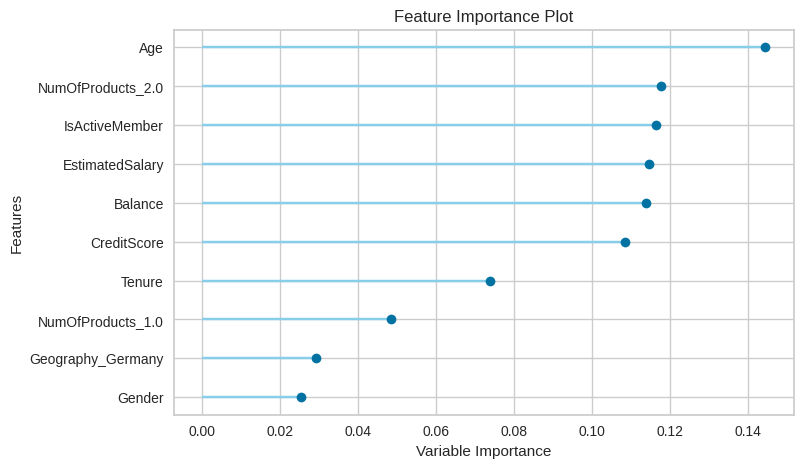

In [125]:
plot_model(rf_over43, plot='feature')

# VI. Scoring

In [126]:
over_43_test = churn_test[churn_test["Age"] >= 43].copy()
under_43_test = churn_test[churn_test["Age"] < 43].copy()

In [127]:
preds_u43_test = predict_model(ridge_under43_final, data=under_43_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7106,0.6776,0.6352,0.2225,0.3295,0.1962,0.2402


In [129]:
preds_o43_test = predict_model(nb_over43, data=over_43_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.6086,0.6934,0.7944,0.5282,0.6345,0.2484,0.2729


In [130]:
test_predictions = pd.concat([preds_u43_test, preds_o43_test], axis=0)

In [131]:
list(test_predictions)

['RowNumber',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'HasBalance',
 'Over43',
 'Exited',
 'prediction_label',
 'prediction_score']

In [132]:
recall = test_predictions[test_predictions["prediction_label"] == 1]["Exited"].sum()/test_predictions["Exited"].sum()

In [133]:
recall

0.7321867321867321

In [134]:
accuracy = (test_predictions["prediction_label"] == test_predictions["Exited"]).mean()

In [135]:
accuracy

0.681